# Analisis para planificar campañas publicitarias de Ice

Ice es una tienda online que vende videojuegos por todo el mundo. Trabajaremos con las reseñas de usuarios y expertos, los géneros, las plataformas y los datos históricos sobre las ventas de juegos en Norteamerica, Japon y Europa. 
Vamos analisar e identificar patrones que determinen si un juego tiene éxito o no, para planificar campañas publicitarias para el 2017

## Importacion de librerias y lectura de datos

In [1]:
#importar librerias necesarias para el analisis 
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from math import factorial
from matplotlib import pyplot as plt 

In [2]:
#leer los datos
gms = pd.read_csv('/datasets/games.csv')
gms

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


## Preparacion de datos

In [3]:
gms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Convertir nombre de las columnas a minusculas

In [4]:
gms.columns = gms.columns.str.lower()

Funcion para convertir el contenido de ciertas las columnas en minusculas 

In [5]:
def lower(gms,col):
    gms[col] = gms[col].str.lower()
    return gms[col]

In [6]:
lower(gms, 'name')
lower(gms, 'platform')
lower(gms, 'genre')

0              sports
1            platform
2              racing
3              sports
4        role-playing
             ...     
16710          action
16711          sports
16712       adventure
16713        platform
16714      simulation
Name: genre, Length: 16715, dtype: object

### Observo valores ausentes

In [7]:
gms.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Los valores nulos de 'year_of_release' son una proporcion minina en comparacion a la cantidad de datos por lo tanto decido dejarlos nulos y decido dejarlo en tipo float porque no afecta a mi analisis 

las columnas 'critic' y 'user_score' decido rellenar los nulos y transformarlas a tipo de dato float

la columna 'rating' decido rellenar los nulos y dejarla como tipo de dato object 

Observo que filas tienen valores nulos en la colmna name y genre

In [8]:
games_null_genre = gms[gms['genre'].isna()]['name']
gms[gms['name'].isin(games_null_genre)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Elimino estas 2 columnas sin nombre ni genero, porque no aportan al analisis.

In [9]:
gms=gms.dropna(subset=['name', 'genre'])

Observo valores unicos de la columna rating 

In [10]:
gms['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Relleno los nulos de rating con RP, puesto que segun ESRB, RP significa rating pending

In [11]:
gms['rating'] = gms['rating'].fillna(value='RP')
gms.isna().sum() #confirmo que elimine los valores nulos en las columnas name, genre y rating 

/tmp/ipykernel_227/1390946063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gms['rating'] = gms['rating'].fillna(value='RP')


name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating                0
dtype: int64

In [12]:
gms['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Decido transformar 'tbd' y nan a -1 para poder transformar la columna 'user_score' a float para realizar un mejor analisis, al igual que la columna 'critic_score'

Transformo los valores nulos de 'critic_score'y 'user_score' a -1 para identificar en el analisis que juegos no fueron calificados 

Decido dejar en valores nulos en year_of_release porque no afecta el analisis

In [13]:

gms['user_score'] = gms['user_score'].replace('tbd',-1)
gms['user_score'] = gms['user_score'].fillna(value='-1')
gms['user_score'] = gms['user_score'].astype(float)
gms['critic_score'] = gms['critic_score'].fillna(value='-1')
gms['critic_score'] = gms['critic_score'].astype(float)
gms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


/tmp/ipykernel_227/2281848433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gms['user_score'] = gms['user_score'].replace('tbd',-1)
/tmp/ipykernel_227/2281848433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gms['user_score'] = gms['user_score'].fillna(value='-1')
/tmp/ipykernel_227/2281848433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

### Calcula las ventas totales (la suma de las ventas en todas las regiones) para cada juego y coloca estos valores en una columna separada.

In [14]:
gms['total_sales'] = gms['na_sales']+ gms['eu_sales']+ gms['jp_sales']+ gms['other_sales']

/tmp/ipykernel_227/1616969050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gms['total_sales'] = gms['na_sales']+ gms['eu_sales']+ gms['jp_sales']+ gms['other_sales']


In [15]:
gms.describe(include='all')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
count,16713,16713,16444.000000,16713,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,16713,16713.000000
unique,11559,31,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN
top,need for speed: most wanted,ps2,NaN,action,NaN,NaN,NaN,NaN,NaN,NaN,RP,NaN
freq,12,2161,NaN,3369,NaN,NaN,NaN,NaN,NaN,NaN,6767,NaN
mean,NaN,NaN,2006.486256,NaN,0.263302,0.145045,0.077625,0.047343,33.064920,2.689888,NaN,0.533315
std,NaN,NaN,5.875525,NaN,0.813565,0.503359,0.308871,0.186742,36.299815,4.169887,NaN,1.548282
min,NaN,NaN,1980.000000,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,NaN,0.000000
25%,NaN,NaN,2003.000000,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,NaN,0.060000
50%,NaN,NaN,2007.000000,NaN,0.080000,0.020000,0.000000,0.010000,-1.000000,-1.000000,NaN,0.170000
75%,NaN,NaN,2010.000000,NaN,0.240000,0.110000,0.040000,0.030000,70.000000,7.300000,NaN,0.470000


## Analisis de datos

### Cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?

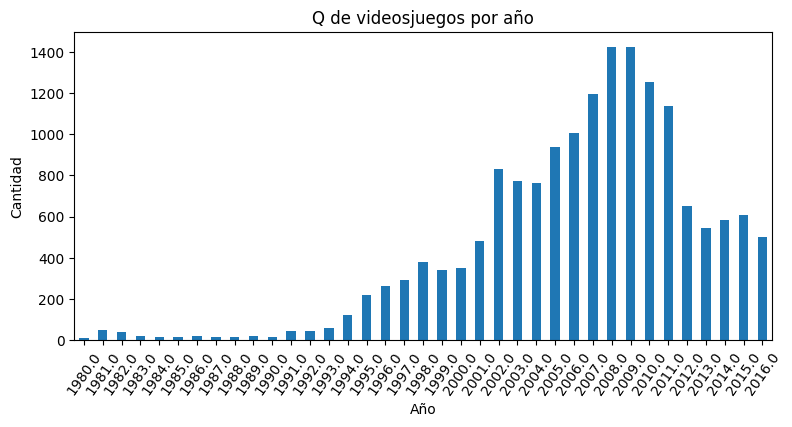

In [16]:
num_gms = gms.groupby('year_of_release')['name'].count()
ax= num_gms.plot(kind='bar'
             , rot=55
             , title='Q de videosjuegos por año'
             , figsize = [9,4]
             , xlabel='Año'
             , ylabel='Cantidad')

En el año 2006 fueron lanzados 1200 juegos

En los años 2007 y 2008 fueron lanzados 1400 juegos cada año, siendo los años con mas lanzamiento de videojuegos 

En el año 2009 fueron lanzados mas de 1200 juegos 

Los datos son significativos desde 2000 al 2016

### Cómo varían las ventas de una plataforma a otra.

<AxesSubplot:title={'center':'Ventas por plataforma'}, xlabel='Plataforma', ylabel='Ventas en usd'>

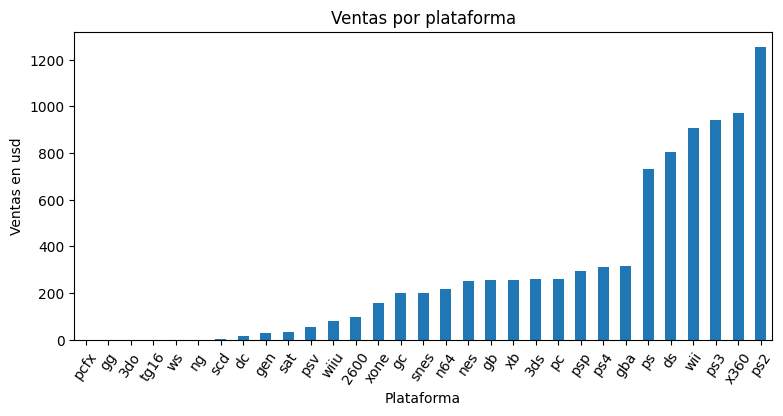

In [17]:
sales_plat = gms.groupby('platform')['total_sales'].sum().sort_values()
sales_plat.plot(kind='bar', rot=55, title='Ventas por plataforma', figsize = [9,4]
             , xlabel='Plataforma', ylabel='Ventas en usd')

# Elige las plataformas con las mayores ventas totales

In [18]:
plat_msales = sales_plat.tail(8)
plat_pop = plat_msales.index
plat_pop

Index(['ps4', 'gba', 'ps', 'ds', 'wii', 'ps3', 'x360', 'ps2'], dtype='object', name='platform')

#y construye una distribución basada en los datos de cada año. 

# histograma? lo hago  no 
agrp = gms.groupby(['year_nonull','platform'])['total_sales'].sum()
agrp.hi(bins=15)
#la mayoria de las plat generan mas de 120millones 
filtro por cada plat y agrupac por año
grafico por pla y agr por año 

In [19]:
agrp = gms.groupby(['year_of_release','platform'])['total_sales'].sum()

# Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?

<AxesSubplot:xlabel='year_of_release', ylabel='total_sales'>

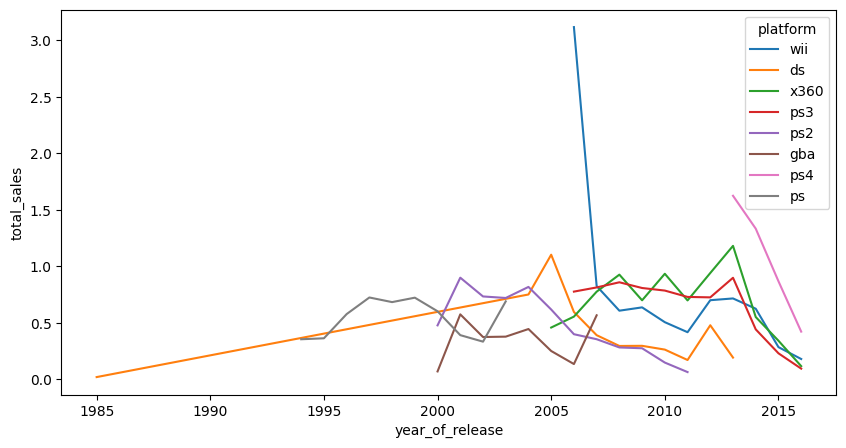

In [20]:
pop = gms[gms['platform'].isin(plat_pop)][['platform','total_sales', 'year_of_release']]
plt.figure(figsize=(10,5))
sns.lineplot(data=pop, x="year_of_release", y="total_sales", hue="platform", ci=None)


'ps2' la plataforma mas vendida, estuvo vigente durante 11 años 


La plataforma que mas se mantuco en el tiempo fue 'ds' con 28 años en el mercado, siendo lanzada en 1985 y retirada en 2013

La plataforma 'ps4' fue lanzada en 2013 y aun sigue vigente


# Periodo determinado para contruir un modelo para 2017

In [21]:
gmss = gms[gms['year_of_release'] > 2001] #hasta 2016 en este periodo tomare datos para hacer el analisis

### ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Plataformas potencialmente rentables.

<AxesSubplot:title={'center':'Ventas de plataformas por año'}, xlabel='year_of_release'>

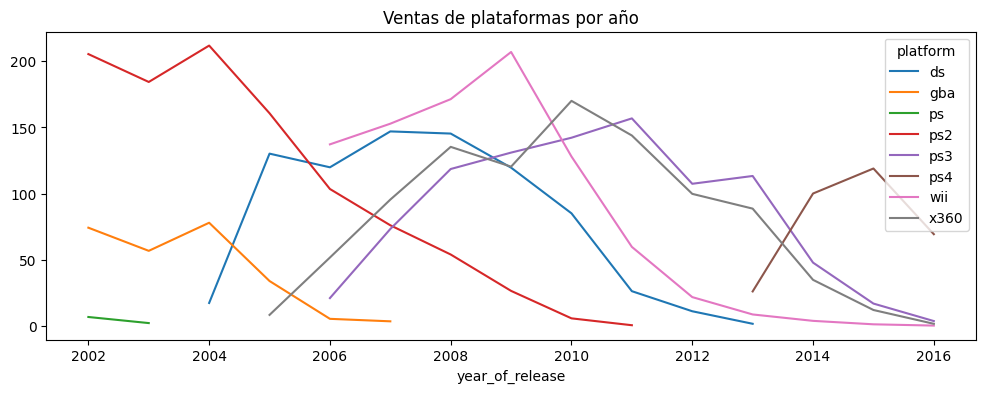

In [22]:
gmss[gmss['platform'].isin(plat_pop)].pivot_table(index='year_of_release'
                                                  , columns='platform'
                                                  ,values='total_sales'
                                                  , aggfunc='sum').plot(kind='line'
                                                                        , figsize=(12,4)
                                                                        , title='Ventas de plataformas por año')

Plataformas lideres en venta: 'ps4', 'gba', 'ps', 'ds', 'wii', 'ps3', 'x360' y 'ps2'

Las ventas de la mayoria de las plataformas se reducen la unica que esta aumentando son las ventas de la plataforma 'ps4'

### Diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma

(0.0, 2.0)

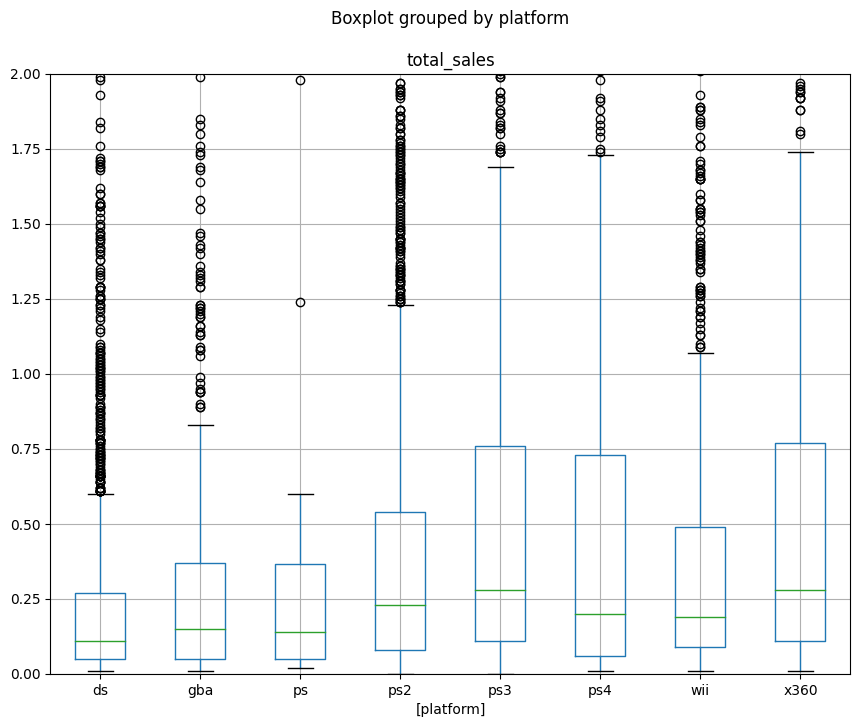

In [23]:
gmss[gmss['platform'].isin(plat_pop)][['platform','total_sales']].boxplot(by='platform'
                                                                        , figsize=(10,8))
plt.ylim(0,2)

¿Son significativas las diferencias en las ventas?
Las ventas de las platarformas 'ps3', 'ps4' y 'x360' son significativas ya que su maximo de ventas es de 1.75 millones dolares aproximadamente

#### Ventas promedio de plataformas mas rentables

<AxesSubplot:title={'center':'Ventas de plataformas por año'}, xlabel='year_of_release'>

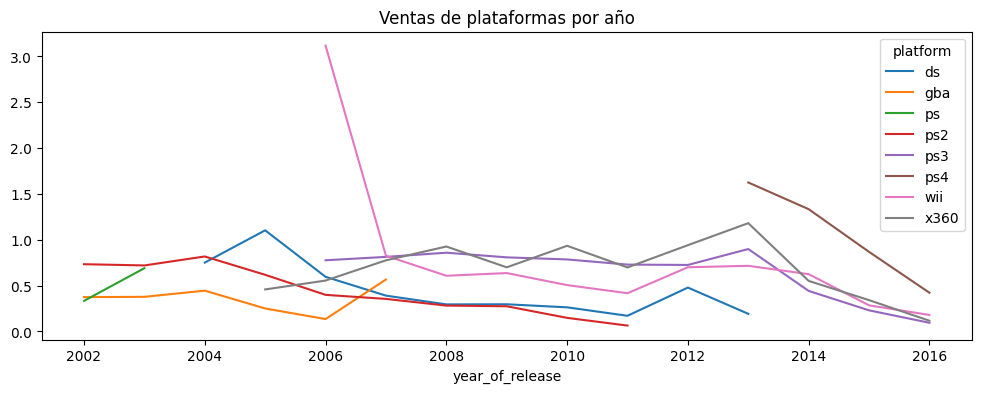

In [24]:
gmss[gmss['platform'].isin(plat_pop)].pivot_table(index='year_of_release'
                                                  , columns='platform'
                                                  ,values='total_sales'
                                                  , aggfunc='mean').plot(kind='line'
                                                                        , figsize=(12,4)
                                                                        , title='Ventas de plataformas por año')

¿Qué sucede con las ventas promedio en varias plataformas? Describe tus hallazgos.

'wii' fue la plataforma que mas ventas promedio tuvo en su lanzamiento pero con el tiempo sus ventas han descendido

'ps4' es la plataforma mas actual que fue lanzada en 2013 y en 2016 sigue teniendo mas ventas que las demas plataformas 

'x360' es una plataforma con ventas promedio irregulares pero hacia el año 2016 va en descenso 

### Cómo las reseñas de usuarios y profesionales afectan las ventas de la plataforma popular x360.

<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

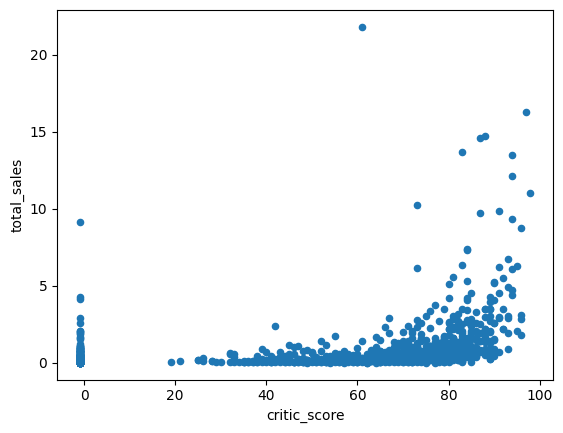

In [25]:
gmss[gmss['platform']=='x360'].plot(kind='scatter', x='critic_score', y='total_sales')

In [26]:
print(gmss[gmss['platform']=='x360']['critic_score'].corr(gmss[gmss['platform']=='x360']['total_sales']))

0.31033008701079257


Correlacion positiva mas cerca de cero por lo tanto no es tan fuerte

Hay una correlacion debil, positiva y curva hacia la derecha entre la calificacion de expertos y las ventas, con pocos valores atípicos.
Existe una correlacion positiva, puesto que a mejor calificacion mayores son las ventas 

<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

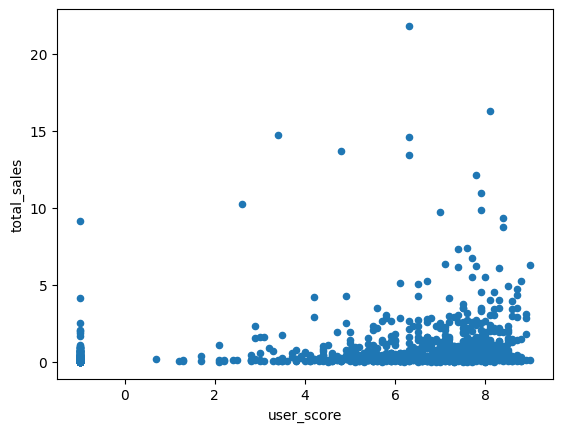

In [27]:
gmss[gmss['platform']=='x360'].plot(kind='scatter', x='user_score', y='total_sales')

In [28]:
print(gmss[gmss['platform']=='x360']['user_score'].corr(gmss[gmss['platform']=='x360']['total_sales']))

0.20618255079822181


Correlacion positiva mas cerca de cero no tan fuerte

Hay una correlacion debil y positiva entre la calificacion de usuarios y las ventas, con varios valores atípicos.
Existe una correlacion positiva, puesto que a mejor calificacion mayores son las ventas 

### Ventas de los mismos juegos en otras plataformas.

In [29]:
gms_plt= gmss.groupby(['name', 'platform'])['total_sales'].sum()
gms_plt

name                                           platform
 beyblade burst                                3ds         0.03
 fire emblem fates                             3ds         1.67
 frozen: olaf's quest                          3ds         0.59
                                               ds          0.51
 haikyu!! cross team match!                    3ds         0.04
                                                           ... 
zumba fitness: world party                     wii         0.23
                                               xone        0.24
zwei!!                                         psp         0.02
zyuden sentai kyoryuger: game de gaburincho!!  3ds         0.05
¡shin chan flipa en colores!                   ds          0.14
Name: total_sales, Length: 13635, dtype: float64

### Distribución general por género.

In [30]:
sales_gne= gmss.groupby('genre')['total_sales'].sum().sort_values().index

(0.0, 2.0)

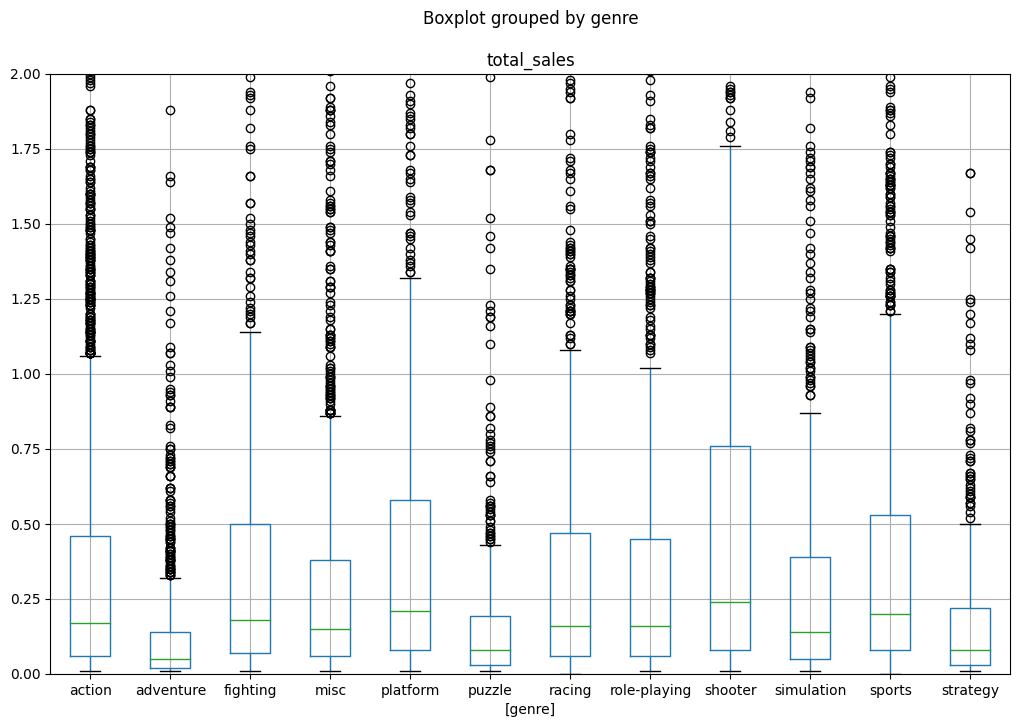

In [31]:
gmss[gmss['genre'].isin(sales_gne)][['genre','total_sales']].boxplot(by='genre'
                                                                        , figsize=(12,8))
plt.ylim(0,2)

¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?

Los generos mas rentables son 'shooter' con unas ventas maximas de 1.75 millones de dolares, le sigue 'platform' con ventas maximas de 1.3 millones de dolares y 'sports' con ventas max de 1.20 mollines de dolares

Y los generos con menos ventas son 'adventure', 'puzzle' y 'strategy'

## Perfil de usuario para cada región

Las cinco plataformas principales de Norteamerica

In [32]:
region = 'na'
region_sales = f'{region}_sales'

plat_pop = gmss.groupby('platform')[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms['platform'].isin(plat_pop)].groupby('platform')[region_sales].sum() / gms[region_sales].sum()

platform
ds      0.086898
ps2     0.132674
ps3     0.089418
wii     0.112917
x360    0.136907
Name: na_sales, dtype: float64

Los cinco generos principales de Norteamerica

In [33]:
region = 'na'
region_sales = f'{region}_sales'
groupby_col = 'genre'

gre_pop = gmss.groupby(groupby_col)[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms[groupby_col].isin(gre_pop)].groupby(groupby_col)[region_sales].sum() / gms[region_sales].sum()

genre
action          0.199749
misc            0.092549
role-playing    0.075174
shooter         0.134583
sports          0.155532
Name: na_sales, dtype: float64

las clasificaciones de ESRB en Norteamerica

In [35]:
region = 'na'
region_sales = f'{region}_sales'
groupby_col = 'rating'

rtg_pop = gmss.groupby(groupby_col)[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms[groupby_col].isin(rtg_pop)].groupby(groupby_col)[region_sales].sum() / gms[region_sales].sum()

rating
E       0.293823
E10+    0.080290
M       0.170087
RP      0.281936
T       0.172648
Name: na_sales, dtype: float64

En Norteamérica la clasificación E (everone) tuvo un 29,3% de las ventas totales de videos juegos. En cuanto a géneros, el genero de acción tuvo casi un 20% de las ventas totales, seguido del genero sports con un 15,5% de las ventas totales

Si nos fijamos en las plataformas x360 y ps2 tuvieron casi un 14% de las ventas totales seguido de la plataforma wii que obtuvo un 11% de las ventas totales 


Las cinco plataformas principales de Europa

In [36]:
region = 'eu'
region_sales = f'{region}_sales'

plat_pop = gmss.groupby('platform')[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms['platform'].isin(plat_pop)].groupby('platform')[region_sales].sum() / gms[region_sales].sum()

platform
ds      0.077920
ps2     0.139963
ps3     0.136250
wii     0.108166
x360    0.111693
Name: eu_sales, dtype: float64

Los cinco generos principales de Europa

In [37]:
region = 'eu'
region_sales = f'{region}_sales'
groupby_col = 'genre'

gre_pop = gmss.groupby(groupby_col)[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms[groupby_col].isin(gre_pop)].groupby(groupby_col)[region_sales].sum() / gms[region_sales].sum()

genre
action     0.214150
misc       0.087759
racing     0.097564
shooter    0.130908
sports     0.155432
Name: eu_sales, dtype: float64

las clasificaciones de ESRB en Europa

In [38]:
region = 'eu'
region_sales = f'{region}_sales'
groupby_col = 'rating'

rtg_pop = gmss.groupby(groupby_col)[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms[groupby_col].isin(rtg_pop)].groupby(groupby_col)[region_sales].sum() / gms[region_sales].sum()

rating
E       0.292991
E10+    0.077768
M       0.199646
RP      0.253030
T       0.176157
Name: eu_sales, dtype: float64

Las cinco plataformas principales de Japon

In [39]:
region = 'jp'
region_sales = f'{region}_sales'

plat_pop = gmss.groupby('platform')[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms['platform'].isin(plat_pop)].groupby('platform')[region_sales].sum() / gms[region_sales].sum()

platform
3ds    0.077597
ds     0.135331
ps2    0.107296
ps3    0.061811
psp    0.059183
Name: jp_sales, dtype: float64

Los cinco generos principales de Japon

In [40]:
region = 'jp'
region_sales = f'{region}_sales'
groupby_col = 'genre'

gre_pop = gmss.groupby(groupby_col)[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms[groupby_col].isin(gre_pop)].groupby(groupby_col)[region_sales].sum() / gms[region_sales].sum()

genre
action          0.124432
misc            0.083332
platform        0.100845
role-playing    0.273953
sports          0.104475
Name: jp_sales, dtype: float64

Clasificaciones de ESRB en Japon

In [41]:
region = 'jp'
region_sales = f'{region}_sales'
groupby_col = 'rating'

rtg_pop = gmss.groupby(groupby_col)[region_sales].sum().sort_values(ascending=False).head(5).index
gms[gms[groupby_col].isin(rtg_pop)].groupby(groupby_col)[region_sales].sum() / gms[region_sales].sum()

rating
E       0.152705
E10+    0.030986
M       0.049517
RP      0.648966
T       0.116700
Name: jp_sales, dtype: float64

## Prueba de hipotesis

### Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

Prueba de igualdad de las medias de dos poblaciones

Hipotesis nula (H0) plantea que la calificacion promedio de los usuarios para la plataforma Xbox One igual a la calificacion promedio de los usuarios de la plataforma PC

H0 = calif_xone = calif_pc 

Hipotesis alternativa (H1) plantea que las calificaciones promedio de los usuarios para las plataformas Xbox One es distinta a la calificacion promedio de los usuarios para la plataforma PC

H1 = calif_xone =! calif_pc

In [42]:
calif_xone= gmss.query("platform =='xone'")['user_score']
calif_pc = gmss.query("platform =='pc'")['user_score']

calif_xone= gmss.query("platform =='xone'")['user_score']
calif_pc = gmss.query("platform =='pc'")['user_score']

Calcular varianzas

In [43]:
var_calif_xone = np.var(calif_xone)
var_calif_pc = np.var(calif_pc)
print(var_calif_xone)
print(var_calif_pc)

12.36705305774558
12.063879704129084


Por lo tanto utilizo el parametro equal_var por defecto

In [44]:
alpha = 0.05
pruebat = st.ttest_ind(calif_xone, calif_pc)
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 0.0005325859279426864
Rechazo la hipotesis


#### Hallazgos

Rechazo la hipotesis nula (H0) que plantea que la calificacion promedio de los usuarios para la plataforma Xbox One igual a la calificacion promedio de los usuarios de la plataforma PC

Por lo tanto acepto la hipotesis alternativa que plantea que las calificaciones promedio de los usuarios para las plataformas Xbox One es distinta a la calificacion promedio de los usuarios para la plataforma PC

### Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Prueba de igualdad de las medias de dos poblaciones

Hipotesis nula (H0) plantea que la calificacion promedio de los usuarios del genero Acccion es igual a la calificacion promedio de los usuarios del genero Deportes

H0 = cal_act = cal_spo 


Hipotesis alternativa (H1) plantea que la calificacion promedio de los usuarios del genero Acccion es diferente a la calificacion promedio de los usuarios del genero Deportes

H1 = cal_act =! cal_spo

In [45]:
cal_act= gmss.query("genre =='action'")['user_score']
cal_spo = gmss.query("genre =='sports'")['user_score']

Calcular varianzas

In [46]:
var_cal_act = np.var(cal_act)
var_cal_spo = np.var(cal_spo)
print(var_cal_act)
print(var_cal_spo)

16.862984975407038
16.85910650824525


Por lo tanto utilizo el parametro equal_var por defecto

In [47]:
alpha = 0.05
pruebat = st.ttest_ind(cal_act, cal_spo)
print('valor p:', pruebat.pvalue)

if (pruebat.pvalue < alpha):
    print('Rechazo la hipotesis')
else:
    print('No puedo rechazar la hipotesis')

valor p: 0.0651705806682025
No puedo rechazar la hipotesis


#### Hallazgos

El vaor p resultante es mayor a 0.05 por lo tanto acepto la hipotesis nulas que plantea la calificacion promedio de los usuarios del genero Acccion es igual a la calificacion promedio de los usuarios del genero Deportes

Y rechazo la hipotesis alternativa 